In [1]:
import os
import fitsio
import desimodel
import astropy
import pandas                as     pd
import pylab                 as     pl
import numpy                 as     np
import astropy.io.fits       as     fits
import matplotlib.pyplot     as     plt

from   datetime              import datetime
from   astropy.table         import Table, vstack, join
from   astropy.coordinates   import Angle, SkyCoord
from   astropy               import units as u

from   desimodel.footprint   import is_point_in_desi
from   desimodel             import io
from   desitarget.geomask    import circles
from   desitarget.targetmask import desi_mask, obsconditions

In [2]:
from   desimodel.focalplane  import get_tile_radius_deg 

In [3]:
def get_hildebrandt(field='D2'):
    # SXDS:  (02:18:00.00, −05:00:00.00), D1 encompassed by W1.  
    dat  = Table.read('/global/cscratch1/sd/mjwilson/DESILBG/Hildebrandt/{}.cat'.format(field))
    
    return  dat

In [4]:
def get_goldrush():
    # https://arxiv.org/pdf/1704.06004.pdf
    dat   = Table.read('/global/homes/m/mjwilson/DESILBG/target/proposals/goldrush/goldrush_mizukizs.fits')    
    
    return dat

In [5]:
def get_laes():
    # https://arxiv.org/pdf/0801.4017.pdf
    dat   = pd.read_csv('/global/homes/m/mjwilson/DESILBG/target/proposals/sxds_laes.txt', sep='\s+', comment='#')
    
    dat.drop(dat.columns[list(np.arange(7, 20, 1))], axis=1, inplace=True)
    
    dat.columns = ['Row', 'Name', 'RA', 'DEC', 'None', 'Velocity', 'Redshift']
    dat['RA']   = [Angle(x).deg for x in dat['RA']]
    dat['DEC']  = [Angle(x[:-1] + '.0s').deg for x in dat['DEC']]
    
    return  dat

In [6]:
def get_vvds():
    # https://cesam.lam.fr/vvds/vvds_download.php
    dat = pd.read_csv('/global/cscratch1/sd/mjwilson/VVDS/cesam_vvds_spF02_DEEP_Full.txt', sep='\s+')

    # Cut.
    dat = dat[dat['Z'] < 9.0]
    
    return dat

In [7]:
def get_splash():
    dat = Table.read('/global/cscratch1/sd/mjwilson/SPLASH/SPLASH_SXDF_Mehta+_v1.6.fits')
    
    return dat

In [8]:
def get_clauds(imaging_bit=1):
    fields           = ['COSMOS', 'DEEP_2', 'ELAIS', 'XMM_LSS']
    clauds           = {}
        
    areas            = {}
    areas['COSMOS']  = {'u': 4.41, 'uS': 4.20, 'g': 7.84,  'r': 7.84,  'i': 7.84,  'z': 7.84,  'y': 7.84}
    areas['XMM-LSS'] = {'u': 0.00, 'uS': 6.80, 'g': 6.38,  'r': 6.38,  'i': 6.38,  'z': 6.38,  'y': 6.38}
    areas['DEEP2-3'] = {'u': 3.70, 'uS': 0.00, 'g': 6.11,  'r': 6.11,  'i': 6.11,  'z': 6.11,  'y': 6.11}
    areas['ELAIS-N'] = {'u': 6.49, 'uS': 0.00, 'g': 10.68, 'r': 10.68, 'i': 10.68, 'z': 10.68, 'y': 10.68}

    for key in areas.keys():
        if imaging_bit == 1:
            del areas[key]['uS']
    
        elif imaging_bit == 2:
            del areas[key]['u']
    
    for field in fields:
        clauds[field] = Table.read('/global/cscratch1/sd/mjwilson/clauds/October2020/{}_v3_v201026.fits'.format(field))

        # Bright star mask & has newer u band data: [HSC, u, Us, J, VirCAM, UDEEP] for FLAG_FIELD_BINARY (imaging_bit). 
        clauds[field] = clauds[field][(clauds[field]['MASK'] == 0) & clauds[field]['FLAG_FIELD_BINARY'][:,imaging_bit] == True]
    
    return  clauds, areas

In [9]:
tile_radius = get_tile_radius_deg()
tiles       = Table(io.load_tiles())

In [10]:
# hiz  = laigle()

In [11]:
# kids = get_kids()

In [12]:
# splash = get_splash()

In [13]:
# splash_zspec = splash[splash['ZSPEC'] > 0.]

In [14]:
# hilde  = get_hildebrandt()

In [15]:
# grush  = get_goldrush()

In [16]:
# laes   = get_laes()

In [17]:
# cfhtls = get_cfhtls_wide()

In [18]:
# vvds   = get_vvds()

In [10]:
clauds, areas = get_clauds()

In [11]:
cclauds  = clauds['COSMOS']

In [12]:
Sclauds, Sareas = get_clauds(imaging_bit=2)

In [13]:
cSclauds = Sclauds['COSMOS']

In [14]:
Hclauds, Hareas = get_clauds(imaging_bit=0)

In [15]:
cHclauds = Hclauds['COSMOS']

In [16]:
cclauds

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [5],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,u,uS,g,r,i,z,y,Yv,J,H,Ks,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,ZPHOT
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
0,149.59750039856772,2.878867531391069,10054,"0,0",0,7,True .. False,5.983199e-05,4.2390246e-05,0.0,18.707382,1.411474,0.29152077,0.01650220434314842,0.00010493658,26.313028,0.35052329301834106,0.90521127,1.1155249,1.290297,28.618,28.469,28.224,28.454,28.143,27.342,-99.021,-99.02,-99.014,-99.009,-99.006,0.321,0.396,0.228,0.409,0.366,0.284,-99.0,-99.0,-99.0,-99.0,-99.0,28.174038,28.644983,28.512594,28.279272,29.47153,28.575283,99.0,1e+20,1e+20,1e+20,1e+20,0.28810936,0.6316033,0.40882772,0.48986953,1.7506987,1.2607428,99.0,1e+20,1e+20,1e+20,1e+20,63.0,-15.932,-15.841,-17.297,-17.537,-18.373,-18.848,-19.151,-19.347,-19.436,-19.465,-19.551,-19.735,-19.507,-99.0,1.3113,0.2992,2.4572,6,0.34828,2.74895,0.441968,26,242,18,1.5941,0.9272,2.2318,-99.0,1.88,12,3000000000.0,0.1,1,876443000.0,8.44477,9.20917,7.81413,9.03823,-0.425113,-0.824061,-0.894037,0.139983,-8.87912,-10.0332,-9.42886,-8.10284,8.151,8.5744,7.88058,0.0,0,1.5941
1,149.54307792888886,2.878899117842753,10054,"0,0",0,7,True .. False,9.388733e-05,4.5947952e-05,4.0,-4.1316705,2.0431647,0.51056325,0.016291514813532786,0.0003912516,25.518118,0.3872963190078736,0.9483222,1.2461437,1.4747574,27.574,28.053,28.085,27.543,26.89,26.906,26.839,-99.02,-99.014,-99.009,-99.006,0.123,0.259,0.198,0.173,0.114,0.186,0.371,-99.0,-99.0,-99.0,-99.0,27.541115,27.956047,27.778364,27.591347,26.928577,26.81956,27.107319,1e+20,1e+20,1e+20,1e+20,0.17674026,0.3514954,0.22487052,0.2763569,0.18269701,0.26761687,0.7439933,1e+20,1e+20,1e+20,1e+20,127.0,-15.423,-14.97,-15.817,-15.93,-16.142,-16.154,-16.172,-16.226,-16.245,-16.234,-16.149,-16.174,-15.916,-99.0,0.7557,0.6459,0.9068,7,2.46672,22.4587,3.58548,27,48,29,0.8746,0.6589,1.2486,-99.0,0.2,10,321031000.0,0.0,0,1198660000.0,7.7489,7.5288,7.45523,8.04443,-1.27257,-1.68193,-1.4498,-0.789413,-9.02023,-9.21073,-9.43064,-8.31573,7.50047,7.48196,6.54335,0.0,0,0.8746
2,149.51906824547063,2.878

In [17]:
cSclauds

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [5],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,u,uS,g,r,i,z,y,Yv,J,H,Ks,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,ZPHOT
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
0,149.59750039856772,2.878867531391069,10054,"0,0",0,7,True .. False,5.983199e-05,4.2390246e-05,0.0,18.707382,1.411474,0.29152077,0.01650220434314842,0.00010493658,26.313028,0.35052329301834106,0.90521127,1.1155249,1.290297,28.618,28.469,28.224,28.454,28.143,27.342,-99.021,-99.02,-99.014,-99.009,-99.006,0.321,0.396,0.228,0.409,0.366,0.284,-99.0,-99.0,-99.0,-99.0,-99.0,28.174038,28.644983,28.512594,28.279272,29.47153,28.575283,99.0,1e+20,1e+20,1e+20,1e+20,0.28810936,0.6316033,0.40882772,0.48986953,1.7506987,1.2607428,99.0,1e+20,1e+20,1e+20,1e+20,63.0,-15.932,-15.841,-17.297,-17.537,-18.373,-18.848,-19.151,-19.347,-19.436,-19.465,-19.551,-19.735,-19.507,-99.0,1.3113,0.2992,2.4572,6,0.34828,2.74895,0.441968,26,242,18,1.5941,0.9272,2.2318,-99.0,1.88,12,3000000000.0,0.1,1,876443000.0,8.44477,9.20917,7.81413,9.03823,-0.425113,-0.824061,-0.894037,0.139983,-8.87912,-10.0332,-9.42886,-8.10284,8.151,8.5744,7.88058,0.0,0,1.5941
1,149.54307792888886,2.878899117842753,10054,"0,0",0,7,True .. False,9.388733e-05,4.5947952e-05,4.0,-4.1316705,2.0431647,0.51056325,0.016291514813532786,0.0003912516,25.518118,0.3872963190078736,0.9483222,1.2461437,1.4747574,27.574,28.053,28.085,27.543,26.89,26.906,26.839,-99.02,-99.014,-99.009,-99.006,0.123,0.259,0.198,0.173,0.114,0.186,0.371,-99.0,-99.0,-99.0,-99.0,27.541115,27.956047,27.778364,27.591347,26.928577,26.81956,27.107319,1e+20,1e+20,1e+20,1e+20,0.17674026,0.3514954,0.22487052,0.2763569,0.18269701,0.26761687,0.7439933,1e+20,1e+20,1e+20,1e+20,127.0,-15.423,-14.97,-15.817,-15.93,-16.142,-16.154,-16.172,-16.226,-16.245,-16.234,-16.149,-16.174,-15.916,-99.0,0.7557,0.6459,0.9068,7,2.46672,22.4587,3.58548,27,48,29,0.8746,0.6589,1.2486,-99.0,0.2,10,321031000.0,0.0,0,1198660000.0,7.7489,7.5288,7.45523,8.04443,-1.27257,-1.68193,-1.4498,-0.789413,-9.02023,-9.21073,-9.43064,-8.31573,7.50047,7.48196,6.54335,0.0,0,0.8746
2,149.51906824547063,2.878

In [18]:
# hilde

In [19]:
# grush_D2 = grush[(grush['ra'] > 148.) & (grush['ra'] < 152.0) & (grush['dec'] > 0.00) & (grush['dec'] < 4.5)]

In [20]:
isin, indx = is_point_in_desi(tiles, cclauds['RA'], cclauds['DEC'], radius=None, return_tile_index=True)

In [21]:
tileids  = np.unique(indx)

In [22]:
cra      = np.median(cclauds['RA'])
cdec     = np.median(cclauds['DEC'])

trad     = tile_radius

Text(0.5, 1.0, 'Clauds COSMOS: (150.1370, 2.2022)')

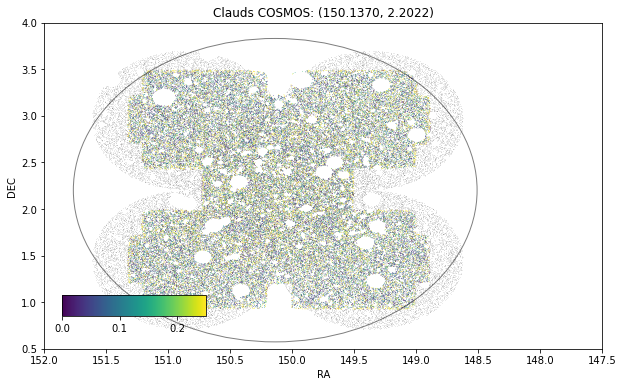

In [23]:
fig, ax  = plt.subplots(1, 1, figsize=(10, 6)) 

im       = pl.scatter(cHclauds['RA'][::50], cHclauds['DEC'][::50], c='k', marker='.', s=2, lw=0.0, vmin=0.0, vmax=.25, alpha=0.1)
im       = pl.scatter(cclauds['RA'][::50], cclauds['DEC'][::50], c=cclauds['u_err'][::50], marker='.', s=2, lw=0.0, vmin=0.0, vmax=.25)
# im     = pl.scatter(hilde['ALPHA_J2000'], hilde['DELTA_J2000'], c=hilde['MAGERR_ISOCOR_u'], marker='.', s=2, lw=0.0, vmin=0.01, vmax=0.8)
# im     = pl.scatter(grush['ra'], grush['dec'], c='g', marker='.', s=2, lw=0.0, vmin=0.01, vmax=0.8, alpha=0.5)

for ind in tileids:    
    # cra  = tiles[ind]['RA']
    # cdec = tiles[ind]['DEC']
    # trad = tile_radius
    
    # print(cra, cdec, trad)
    
    circles(cra, cdec, trad, c='k', fc="None", alpha=0.5)
    
    break
    
ax.set_xlim(152., 147.5)
ax.set_ylim( 0.5,   4.0)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

cax      = fig.add_axes([0.15, 0.2, 0.2, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')

ax.set_title('Clauds COSMOS: ({:.4f}, {:.4f})'.format(cra, cdec))

In [24]:
!pwd

/global/u2/m/mjwilson/DESILBG/target/proposals/docs


In [26]:
pl.savefig('clauds_field.pdf')

<Figure size 432x288 with 0 Axes>

In [27]:
def liu_udrops(clauds, band='r', magmin=0.0, maglim=35.):
    '''
    u-drop color selection.
    '''
    
    assert  np.all(clauds['FLAG_FIELD_BINARY'][:,1] == True)
    
    isin = clauds['g'] - clauds['r'] < 1.2
    isin = isin & (clauds['u'] - clauds['g'] > 0.88)
    isin = isin & (clauds['u'] - clauds['g'] > 1.99 * (clauds['g'] - clauds['r']) + 0.68)
    isin = isin & (clauds[band] < maglim)
    isin = isin & (clauds[band] > magmin)
    
    return  isin

In [28]:
def hilde_usdrops(clauds, band='r', magmin=0.0, maglim=35.):
    '''
    uS-drop color selection.
    '''
    
    assert  np.all(clauds['FLAG_FIELD_BINARY'][:,2] == True)
    
    isin = clauds['g'] - clauds['r'] < 1.2
    isin = isin & (clauds['uS'] - clauds['g'] > 0.90)
    isin = isin & (clauds['uS'] - clauds['g'] > 1.50 * (clauds['g'] - clauds['r']) + 0.75)
    isin = isin & (clauds[band] < maglim)
    isin = isin & (clauds[band] > magmin)
    
    return  isin

In [29]:
udrops    = cclauds[liu_udrops(cclauds)]
usdrops   = cSclauds[hilde_usdrops(cSclauds)]

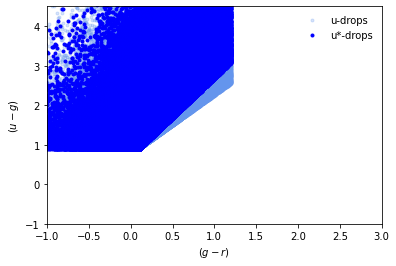

In [30]:
pl.plot(usdrops['g'] - usdrops['r'], usdrops['uS'] - usdrops['g'], marker='.', c='cornflowerblue', lw=0.0, alpha=0.25, label='u-drops')
pl.plot(udrops['g'] - udrops['r'], udrops['u'] - udrops['g'], marker='.', c='b', lw=0.0, label='u*-drops')

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(u-g)$')

pl.legend(frameon=False)

In [54]:
pl.savefig('clauds-udrop-color-selection.pdf')

<Figure size 432x288 with 0 Axes>

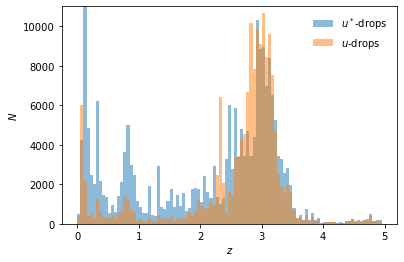

In [33]:
bins = np.arange(0.0, 5.0, 0.05)

pl.hist(usdrops['Z_BEST'], bins=bins, alpha=0.5, label='$u^*$-drops')
pl.hist( udrops['Z_BEST'], bins=bins, alpha=0.5, label='$u$-drops')

pl.ylim(0.0, 1.1e4)

pl.xlabel(r'$z$')
pl.ylabel(r'$N$')

pl.legend(frameon=False)

In [34]:
zmax       = 1.5
interloper = udrops[udrops['Z_BEST'] < zmax]
highz      = udrops[udrops['Z_BEST'] > zmax]

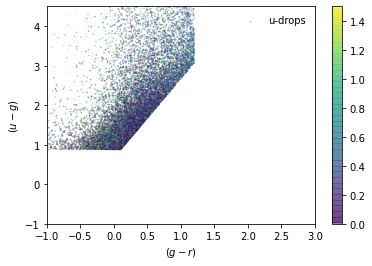

In [35]:
pl.scatter(interloper['g'] - interloper['r'], interloper['u'] - interloper['g'], marker='.', c=interloper['Z_BEST'], alpha=0.5, label='u-drops', vmin=0.0, vmax=zmax, s=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(u-g)$')

pl.colorbar()

pl.legend(frameon=False)

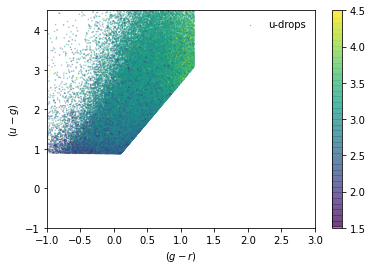

In [36]:
pl.scatter(highz['g'] - highz['r'], highz['u'] - highz['g'], marker='.', c=highz['Z_BEST'], alpha=0.5, label='u-drops', vmin=zmax, vmax=4.5, s=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(u-g)$')

pl.colorbar()

pl.legend(frameon=False)

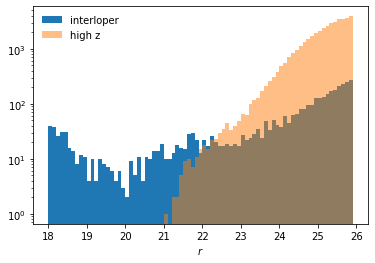

In [37]:
bins = np.arange(18., 26., 0.1)

pl.hist(interloper['r'], bins=bins, label='interloper')
pl.hist(     highz['r'], bins=bins, alpha=0.5, label='high z')

pl.yscale('log')

pl.xlabel(r'$r$')

pl.legend(frameon=False)

In [38]:
rlim_udrops = cclauds[liu_udrops(cclauds, band='r', magmin=21., maglim=26.)]

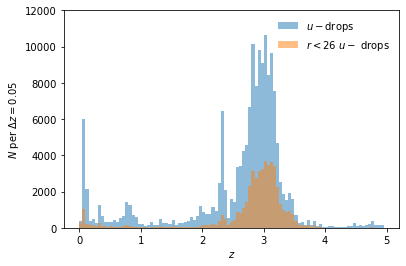

In [57]:
dz          = 0.05
bins        = np.arange(0.0, 5.0, dz)

pl.hist(udrops['Z_BEST'], bins=bins, alpha=0.5, label=r'$u-$drops')
pl.hist(rlim_udrops['Z_BEST'], bins=bins, alpha=0.5, label=r'$r<26$ $u-$ drops')

pl.ylim(0.0, 1.2e4)

pl.xlabel(r'$z$')
pl.ylabel(r'$N$ per $\Delta z={:.2f}$'.format(dz))

pl.legend(frameon=False)

In [58]:
pl.savefig('clauds-udrop-redshift-distribution.pdf')

<Figure size 432x288 with 0 Axes>

In [41]:
len(rlim_udrops) / areas['COSMOS']['u']

11029.251700680272

In [42]:
def flatmagcat(rlimcat, band):
    bins       = np.arange(21., 26.01, 0.1)
    
    assert  rlimcat[band].max() < 26.0
    
    result     = np.histogram(rlimcat[band], bins=bins)

    cnts, bins = result[0], result[1]
    lims       = bins[:-1]
     
    cut        = lims[cnts > 0.5 * np.median(cnts[cnts > 0])][0]
    
    # print(cnts)

    rsampling                  = cnts / cnts[cnts > 0.25 * np.median(cnts[cnts > 0])][0]    
    rsampling[rsampling < 1.]  = 1.0
    rsampling                  = 1. / rsampling
        
    rsampling                  = np.concatenate((rsampling, np.array([0])))
        
    indx                       = np.digitize(rlimcat[band], bins)
    
    sampling                   = np.random.uniform(0.0, 1.0, len(rlimcat))
    
    rlimcat['SAMPLING']        = sampling < rsampling[indx]

    print('{:.1f} \t {:d}'.format(cut, np.count_nonzero(rlimcat['SAMPLING'])))
    
    # In, residual.
    return  rlimcat[rlimcat['SAMPLING']], rlimcat[~rlimcat['SAMPLING']]

23.0 	 1886
23.8 	 5041
24.4 	 7283
24.7 	 7220
24.8 	 4919
25.0 	 4443
25.1 	 3604
25.2 	 2557
25.3 	 1739
25.4 	 1129

-------------------------

39821 	 48639


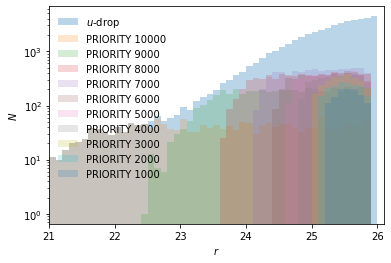

In [59]:
bins                       = np.arange(21., 26.1, 0.1)
result                     = pl.hist(rlim_udrops['r'], bins=bins, alpha=0.3, label=r'$u$-drop')
reducecat                  = Table(rlim_udrops, copy=True)

tiers = []
total =  0

for i in np.arange(10):    
    flat_udrops, reducecat = flatmagcat(reducecat, 'r')
    result                 = pl.hist(flat_udrops['r'], bins=bins, alpha=0.2, label='PRIORITY {}'.format(10000 - i * 1000))
        
    tiers.append(flat_udrops)
    
    total += len(flat_udrops)
    
print('\n-------------------------\n')
print('{} \t {}'.format(total, len(rlim_udrops)))

pl.xlim(21., 26.1)

pl.xlabel(r'$r$')
pl.ylabel(r'$N$')

pl.yscale('log')

pl.legend(frameon=False)

In [60]:
pl.savefig('clauds-udrop-magnitude-distribution.pdf')

<Figure size 432x288 with 0 Axes>

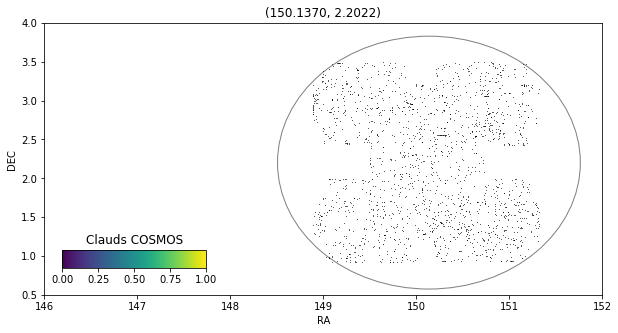

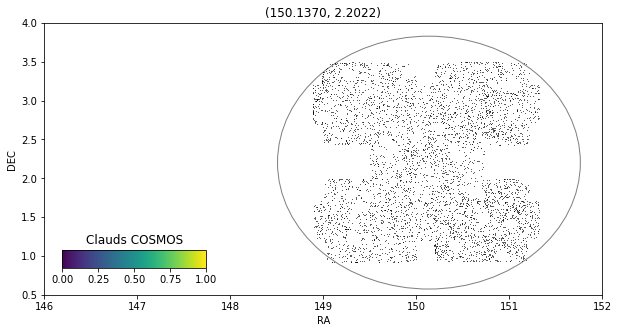

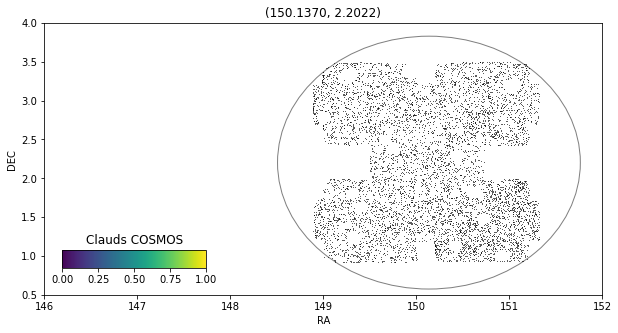

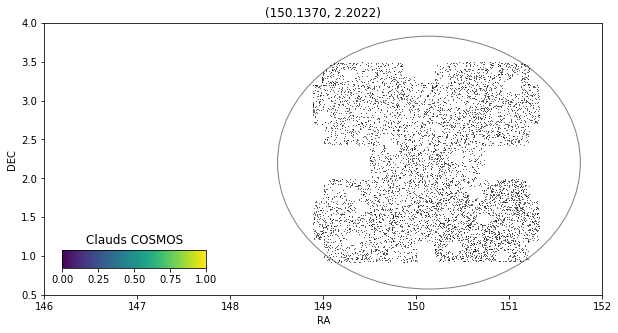

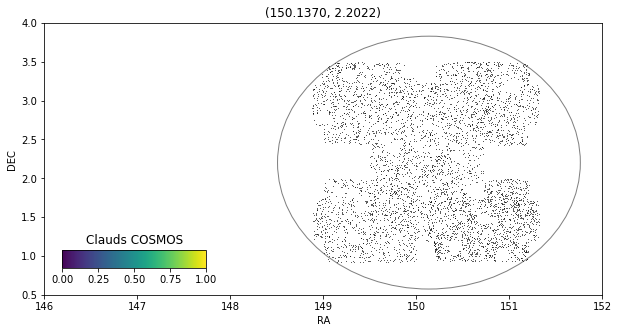

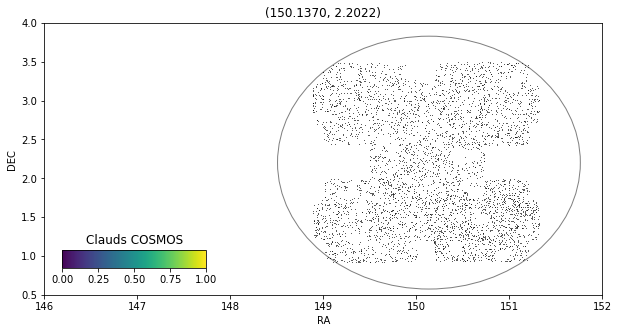

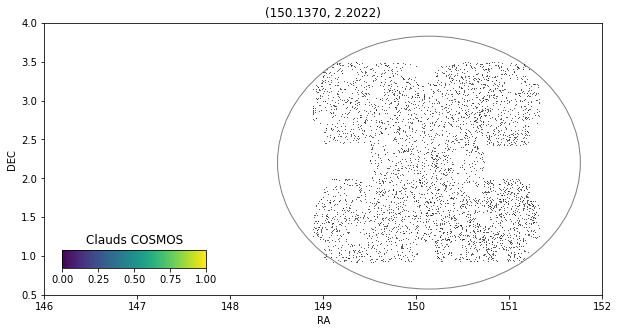

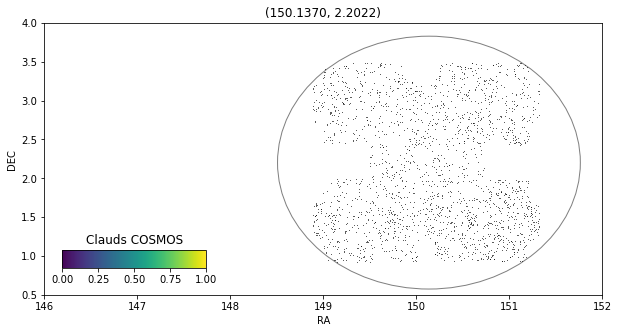

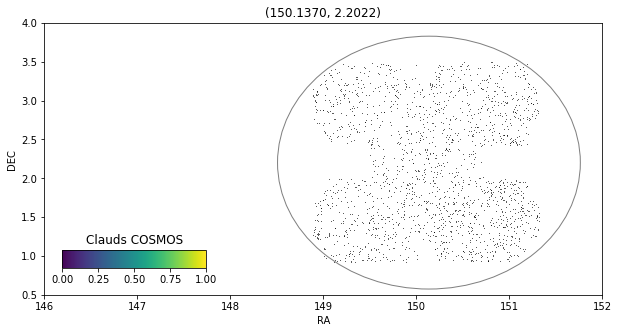

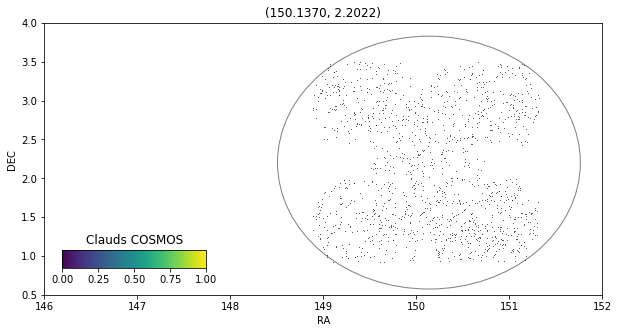

In [45]:
for i, tier in enumerate(tiers):
    tier['PRIORITY'] = 10000 - 1000 * i
    
    fig, ax  = plt.subplots(1, 1, figsize=(10, 5)) 

    im       = pl.scatter(tier['RA'], tier['DEC'], c='k', marker='.', s=2, lw=0.0, vmin=0.0, vmax=.25)

    for ind in tileids:    
        # cra  = tiles[ind]['RA']
        # cdec = tiles[ind]['DEC']
        # trad = tile_radius
    
        # print(cra, cdec, trad)
    
        circles(cra, cdec, trad, c='k', fc="None", alpha=0.5)
    
        break
    
    ax.set_xlim(146., 152.)
    ax.set_ylim( 0.5,  4.0)

    ax.set_xlabel('RA')
    ax.set_ylabel('DEC')

    ax.set_title('({:.4f}, {:.4f})'.format(cra, cdec))
    
    cax      = fig.add_axes([0.15, 0.2, 0.2, 0.05])
    fig.colorbar(im, cax=cax, orientation='horizontal')

    pl.title('Clauds COSMOS')

In [46]:
final_cat                 = Table()

In [47]:
for tier in tiers:
    final_cat             = vstack((final_cat, tier))

In [48]:
isin, indx                = is_point_in_desi(tiles, final_cat['RA'], final_cat['DEC'], radius=None, return_tile_index=True)

In [49]:
final_cat['TILEID']       = tiles['TILEID'][indx]

In [50]:
final_cat['SAMPLE']       = 'clauds-u'
final_cat['TARGETID']     = np.arange(len(final_cat))
final_cat['SUBPRIORITY']  = np.random.uniform(0.0, 1.0, len(final_cat))

final_cat['PMRA']         = np.zeros(len(final_cat),   dtype='>f4')
final_cat['PMDEC']        = np.zeros(len(final_cat),   dtype='>f4')

final_cat['REF_EPOCH']    = np.zeros(len(final_cat),   dtype='>f4')
final_cat['OVERRIDE']     = np.zeros(len(final_cat),   dtype='>f4')

final_cat.meta['EXTNAME'] = 'MTL'

In [51]:
final_cat

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [5],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,u,uS,g,r,i,z,y,Yv,J,H,Ks,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,ZPHOT,SAMPLING,PRIORITY,TILEID,SAMPLE,TARGETID,SUBPRIORITY,PMRA,PMDEC,REF_EPOCH,OVERRIDE
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,bool,int64,int32,str8,int64,float64,float32,float32,float32,float32
867,149.41961938244873,2.8829715922708776,10054,"0,0",0,7,True .. False,0.0002120269,0.00015872197,4.0,49.79489,1.3355727,0.25125754,0.017631114614015543,0.00016539743,21.09455,0.9808672070503236,0.8692421,1.2679545,1.6483809,25.06,24.224,22.298,21.955,21.755,21.671,21.512,-99.021,-99.015,-99.01,-99.006,0.054,0.033,0.005,0.005,0.005,0.007,0.016,-99.0,-99.0,-99.0,-99.0,25.426678,24.541346,22.550116,22.139679,21.929672,21.835365,21.726545,1e+20,1e+20,1e+20,1e+20,0.030757893,0.01767291,0.0026074382,0.0025778331,0.0026885837,0.0036080093,0.008307366,1e+20,1e+20,1e+20,1e+20,127.0,-23.683,-24.099,-24.038,-24.096,-24.169,-24.103,-24.093,-24.134,-24.151,-24.148,-24.121,-24.118,-23.788,-99.0,3.2037,3.1985,3.2032,7,306.435,309.934,60.2533,33,65,24,3.2008,3.1867,3.2145,-99.0,3.02,11,50000000.0,0.1,2,51426700.0,10.1128,10.1116,10.07,11.2674,2.51838,2.45425,2.43428,2.74351,-7.69558,-7.65739,-8.11256,-7.61102,11.2405,10.6377,9.57281,2.0,1,3.2008,True,10000,11155,clauds-u,0,0.17825579145647075,0.0,0.0,0.0,0.0
1557,149.47354133780823,2.8925882609832305,10054,"0,0",0,7,True .. False,0.0001778166,0.00010409655,4.0,67.68066,1.7075791,0.4143756,0.017686683608573804,0.0003978816,24.697592,0.7810378074645996,1.0881746,1.6353916,2.0865178,28.248,27.501,26.048,25.7,25.685,25.624,25.381,-99.021,-99.015,-99.01,-99.006,0.322,0.203,0.043,0.045,0.056,0.084,0.148,-99.0,-99.0,-99.0,-99.0,28.320549,27.791208,25.700628,25.36164,25.308578,25.352493,25.288399,1e+20,1e+20,1e+20,1e+20,0.44212472,0.3412111,0.040649734,0.04411589,0.05325229,0.08886989,0.18541378,1e+20,1e+20,1e+20,1e+20,127.0,-19.788,-19.866,-20.282,-20.374,-20.608,-20.7,-20.795,-20.894,-20.937,-20.945,-20.973,-21.011,-20.72,-99.0,2.8223,2.7583,3.1346,7,0.738633,7.47946,0.587003,18,56

In [52]:
final_cat['r'].max()

25.9

In [53]:
final_cat.write('/global/cscratch1/sd/mjwilson/DESILBG/final/udrop-targetlist.fits', overwrite=True)

Text(0, 0.5, 'DEC')

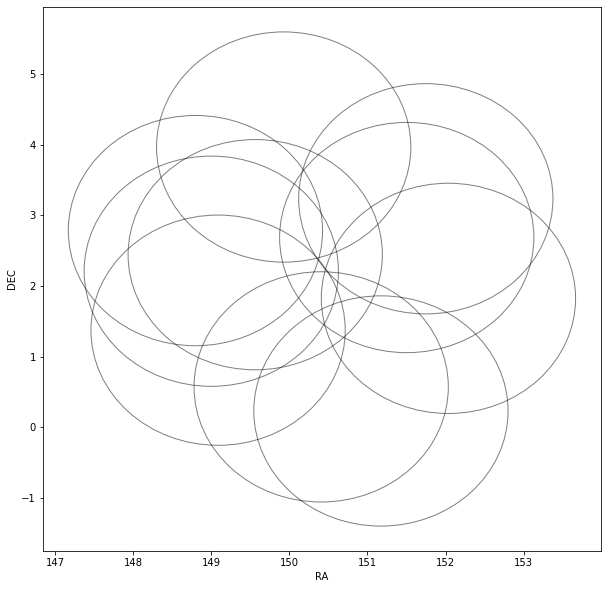

In [127]:
fig, ax  = plt.subplots(1, 1, figsize=(10, 10)) 

for ind in np.unique(indx):        
    circles(tiles['RA'][ind], tiles['DEC'][ind], trad, c='k', fc="None", alpha=0.5)
    
pl.xlabel('RA')
pl.ylabel('DEC')

# BX selection

In [69]:
def bx(cat, rmin=22., rmax=24.5):
    # https://arxiv.org/pdf/0903.3951.pdf    
    isin  = np.ones(len(cat), dtype=bool)

    cat['u-g'] = cat['u'] - cat['g']
    cat['g-r'] = cat['g'] - cat['r']
    
    # LATIS, https://arxiv.org/pdf/2002.10676.pdf
    # 0.5 < u − g < 2.2 and −0.1 < g − r < 1.0 and u − g > 0.50 + 2.3(g − r − 0.35).
    isin &= cat['u-g'] >  0.0
    isin &= cat['u-g'] <  3.0
    isin &= cat['g-r'] > -0.5
    isin &= cat['g-r'] <  1.0
    isin &= cat['u-g'] >  1.0 + 2.3 * (cat['g-r'] - 0.35)
    
    isin  = isin & (cat['r'] > rmin)
    isin  = isin & (cat['r'] < rmax)
    
    return  isin

In [70]:
bx_cclauds     = cclauds[bx(cclauds, rmin=0.)]
rlimbx_cclauds = cclauds[bx(cclauds, rmin=21.)]

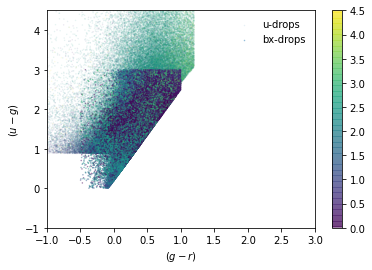

In [71]:
pl.scatter(highz['g'] - highz['r'], highz['u'] - highz['g'], marker='.', c=highz['Z_BEST'], alpha=0.1, label='u-drops', vmin=zmax, vmax=4.5, s=1)
pl.scatter(bx_cclauds['g'] - bx_cclauds['r'], bx_cclauds['u'] - bx_cclauds['g'], marker='.', c=bx_cclauds['Z_BEST'], alpha=0.5, label='bx-drops', vmin=0.0, vmax=4.5, s=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(u-g)$')

pl.colorbar()

pl.legend(frameon=False)

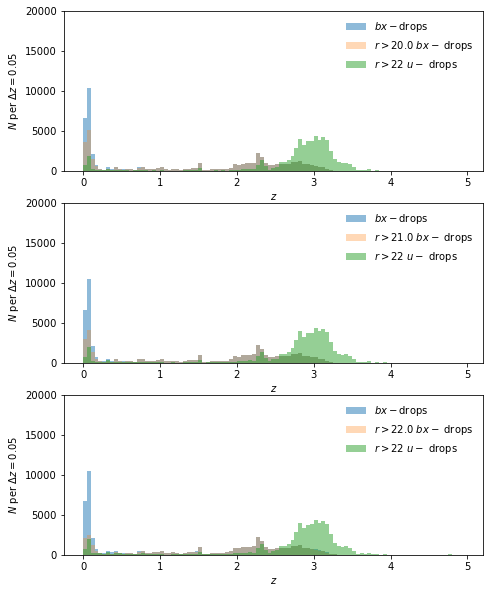

In [72]:
fig, axes = plt.subplots(3, 1, figsize=(7.5, 10))

for i, rmin in enumerate([20.0, 21.0, 22.0]):
    rlimbx_cclauds = cclauds[bx(cclauds, rmin=rmin)]
    
    dz   = 0.05
    bins = np.arange(0.0, 5.0, dz)

    axes[i].hist(bx_cclauds['Z_BEST'], bins=bins, alpha=0.5, label=r'$bx-$drops')
    axes[i].hist(rlimbx_cclauds['Z_BEST'], bins=bins, alpha=0.3, label=r'$r>{:.1f}$ $bx-$ drops'.format(rmin))

    axes[i].hist(u_rlimsample['Z_BEST'], bins=bins, alpha=0.5, label=r'$r>22$ $u-$ drops')

    axes[i].set_ylim(0.0, 2.e4)

    axes[i].set_xlabel(r'$z$')
    axes[i].set_ylabel(r'$N$ per $\Delta z={:.2f}$'.format(dz))

    axes[i].legend(frameon=False)

In [73]:
rlimbx_cclauds                     = cclauds[bx(cclauds, rmin=22.)]

18343
9236
7698
3679


ValueError: zero-size array to reduction operation maximum which has no identity

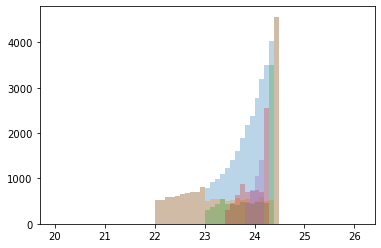

In [74]:
bins                               = np.arange(20., 26.1, 0.1)
result                             = pl.hist(rlimbx_cclauds['r'], bins=bins, alpha=0.3, label=r'$bx$-drop')
reducecat                          = Table(rlimbx_cclauds, copy=True)

tiers = []

for i in np.arange(5):    
    bx_rlimflatsample, reducecat   = flatmagcat(reducecat, 'r')
    result                         = pl.hist(bx_rlimflatsample['r'], bins=bins, alpha=0.3, label='PRIORITY {}'.format(10000 - i * 1000))
    
    print(len(bx_rlimflatsample))
    
    tiers.append(bx_rlimflatsample)
    
pl.xlim(21.9, 26.)
    
pl.xlabel(r'$r$')
pl.ylabel(r'$N$')

pl.legend(frameon=False)

# g-dropouts

In [552]:
goldrush = get_goldrush()

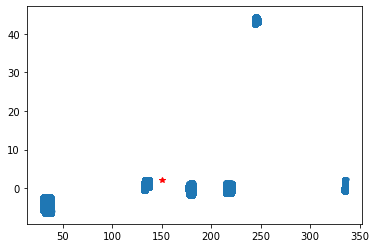

In [555]:
pl.plot(goldrush['ra'], goldrush['dec'], marker='.', lw=0.0)
pl.plot(cra, cdec, marker='*', c='r')

In [556]:
cra, cdec

(150.03503956057787, 2.2087474889379277)

In [669]:
def gdrop(cat, imin=22., imax=26., intercept=1.3):
    # https://arxiv.org/pdf/0903.3951.pdf    
    isin  = np.ones(len(cat), dtype=bool)

    cat['r-i'] = cat['r'] - cat['i']
    cat['g-r'] = cat['g'] - cat['r']
    
    # LATIS, https://arxiv.org/pdf/2002.10676.pdf
    # 0.5 < u − g < 2.2 and −0.1 < g − r < 1.0 and u − g > 0.50 + 2.3(g − r − 0.35).
    isin &= cat['g-r'] >  1.1
    isin &= cat['r-i'] <  1.0
    
    # isin &= cat['g-r'] >  0.9 * cat['r-i'] + 1.6
    # isin &= cat['g-r'] >  0.9 * cat['r-i'] + 1.3
    isin &= cat['g-r'] >  0.9 * cat['r-i'] + 1.0
    
    isin  = isin & (cat['i'] > imin)
    isin  = isin & (cat['i'] < imax)
    
    return  isin

In [688]:
g_cclauds     = cclauds[gdrop(cclauds, imin=0.)]
gilim_cclauds = cclauds[gdrop(cclauds, imin=23.)]

No handles with labels found to put in legend.


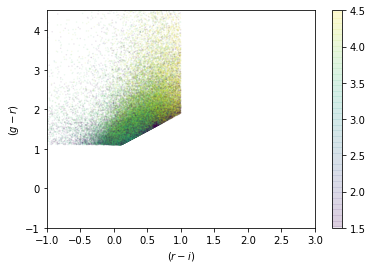

In [689]:
pl.scatter(g_cclauds['r'] - g_cclauds['i'], g_cclauds['g'] - g_cclauds['r'], marker='.', c=g_cclauds['Z_BEST'], alpha=0.1, label='', vmin=zmax, vmax=4.5, s=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(r-i)$')
pl.ylabel(r'$(g-r)$')

pl.colorbar()

pl.legend(frameon=False)

In [690]:
interlopers = g_cclauds[g_cclauds['Z_BEST'] < 1.5]

No handles with labels found to put in legend.


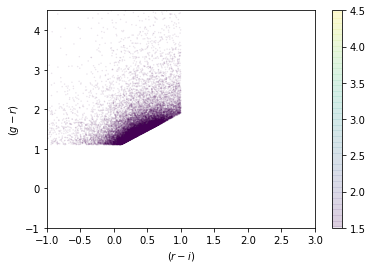

In [691]:
pl.scatter(interlopers['r'] - interlopers['i'], interlopers['g'] - interlopers['r'], marker='.', c=interlopers['Z_BEST'], alpha=0.1, label='', vmin=zmax, vmax=4.5, s=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(r-i)$')
pl.ylabel(r'$(g-r)$')

pl.colorbar()

pl.legend(frameon=False)

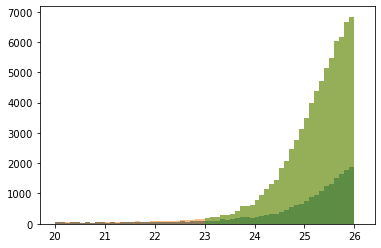

In [694]:
_ = pl.hist(interlopers['i'], bins=np.arange(20., 26.1, 0.1))
_ = pl.hist(g_cclauds['i'], bins=np.arange(20., 26.1, 0.1), alpha=0.5)
_ = pl.hist(gilim_cclauds['i'], bins=np.arange(20., 26.1, 0.1), alpha=0.5)

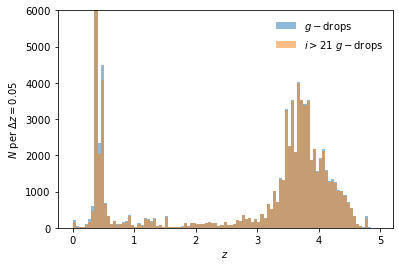

In [695]:
dz   = 0.05
bins = np.arange(0.0, 5.0, dz)

pl.hist(g_cclauds['Z_BEST'], bins=bins, alpha=0.5, label=r'$g-$drops')
pl.hist(gilim_cclauds['Z_BEST'], bins=bins, alpha=0.5, label=r'$i >21 \ g-$drops')

pl.ylim(0.0, 6.e3)

pl.xlabel(r'$z$')
pl.ylabel(r'$N$ per $\Delta z={:.2f}$'.format(dz))

pl.legend(frameon=False)

In [697]:
len(gilim_cclauds)

74518

# Done.